In [17]:
pip install pydot

In [18]:
pip install tensorflow

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Pokemon_Authentication_w1830176'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns

In [21]:
pip install split-folders

In [22]:

import splitfolders


input_folder = '/content/drive/MyDrive/Pokemon_Authentication_w1830176/DataSet'


splitfolders.ratio(input_folder, output='/content/drive/MyDrive/Pokemon_Authentication_w1830176/OutPut',
                   seed=42, ratio=(.8, .2),
                   group_prefix=None)

Copying files: 452 files [03:54,  1.93 files/s]


In [23]:
size = 224

train_path = "/content/drive/MyDrive/Pokemon_Authentication_w1830176/train"
val_path = "/content/drive/MyDrive/Pokemon_Authentication_w1830176/valid"

### Validate dataset

In [24]:
def check_file_type(image_folder_path, allowed_extensions=None):
    if allowed_extensions is None:
        allowed_extensions = ['.jpg']

    no_files_in_folder = len(glob.glob(image_folder_path+"/*"))
    extension_type = ""
    no_files_allowed = 0

    for ext in allowed_extensions:
      no_files_allowed = len(glob.glob(image_folder_path+"/*"+ext))
      if no_files_allowed > 0:
        extension_type = ext
        break

    assert no_files_in_folder == no_files_allowed, "Found more than one extensions"
    return extension_type


<ipython-input-25-d5b0f8569c33>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, n)


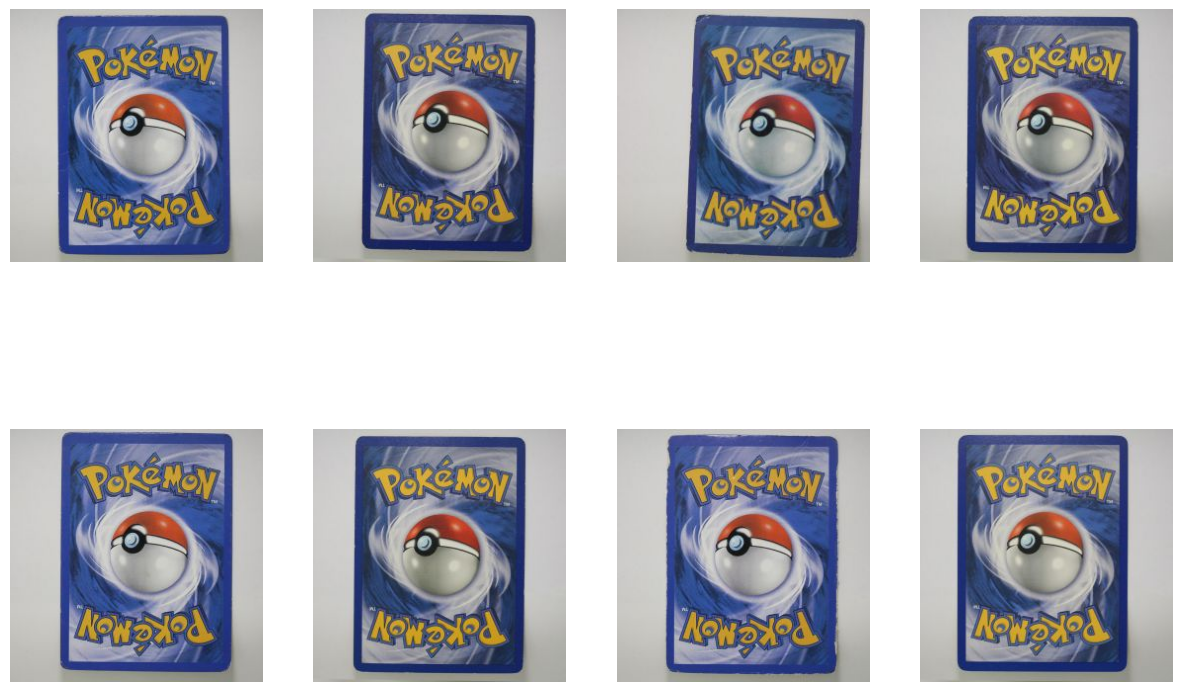

In [25]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Define the readImage function
def readImage(path):
    # OpenCV reads the image in BGR format by default
    bgr_img = cv2.imread(path)
    # Convert BGR image to RGB for display
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return rgb_img

base_tile_dir = '/content/drive/MyDrive/Pokemon_Authentication_w1830176/train'  # Replace with the path to your dataset

# Collect image paths for real and fake cards
real_images = [os.path.join(base_tile_dir, 'Real', image) for image in os.listdir(os.path.join(base_tile_dir, 'Real'))]
fake_images = [os.path.join(base_tile_dir, 'Fake', image) for image in os.listdir(os.path.join(base_tile_dir, 'Fake'))]

plt.figure(1, figsize=(15, 10))  # Increase figsize to accommodate more images
plt.axis('off')
n = 0
for i in range(2):  # Increase the range to display more rows of images
    for j in range(4):  # Display 4 images per row
        n += 1
        if n % 2 == 0:  # Display real card
            random_img = random.choice(real_images)
        else:  # Display fake card
            random_img = random.choice(fake_images)

        img = readImage(random_img)  # Use readImage function to load the image
        plt.subplot(2, 4, n)
        plt.imshow(img)
        plt.axis('off')

plt.show()


### Pre-process and augment data

In [26]:
train_generator = ImageDataGenerator(rotation_range=60,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

valid_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)


train_set = train_generator.flow_from_directory(train_path,
                                                target_size = (size, size),
                                                shuffle=True,

                                                batch_size = 32 )


valid_set = valid_generator.flow_from_directory(val_path,
                                                target_size = (size, size),
                                                shuffle=False,

                                                batch_size = 32 )

Found 336 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [27]:
from collections import Counter

counter = Counter(train_set.classes)

print(counter.items())

dict_items([(0, 110), (1, 226)])


### Load and Modify ResNet50

In [28]:
resNet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(size,size,3),
    pooling="avg",
    classes=2,
)

94765736/94765736 [==============================] - 0s 0us/step


In [29]:
for layer in resNet.layers[:-8]:
    layer.trainable = False

In [30]:
for layer in resNet.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [31]:
resNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [32]:
resnet_model = Sequential()

resnet_model.add(resNet)
resnet_model.add(Flatten())

resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(2, activation='softmax',name='output'))

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 2)                 2

### Plot built model

In [33]:
# from tensorflow.keras.utils import plot_model

# plot_model(resnet_model, to_file='model.png',show_shapes=True, show_layer_names=True)

### Compile and Train the model

In [34]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
model = resnet_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=10
)

Epoch 1/10
11/11 [==============================] - 134s 11s/step - loss: 0.8164 - accuracy: 0.6667 - val_loss: 4.9626 - val_accuracy: 0.6579
Epoch 2/10
11/11 [==============================] - 51s 5s/step - loss: 0.5327 - accuracy: 0.7798 - val_loss: 5.7463 - val_accuracy: 0.6842
Epoch 3/10
11/11 [==============================] - 51s 5s/step - loss: 0.2976 - accuracy: 0.8631 - val_loss: 2.6344 - val_accuracy: 0.7368
Epoch 4/10
11/11 [==============================] - 50s 5s/step - loss: 0.1850 - accuracy: 0.9256 - val_loss: 5.2133 - val_accuracy: 0.7105
Epoch 5/10
11/11 [==============================] - 51s 5s/step - loss: 0.1438 - accuracy: 0.9494 - val_loss: 3.0172 - val_accuracy: 0.7632
Epoch 6/10
11/11 [==============================] - 50s 5s/step - loss: 0.1372 - accuracy: 0.9583 - val_loss: 1.1242 - val_accuracy: 0.8684
Epoch 7/10
11/11 [==============================] - 51s 5s/step - loss: 0.1530 - accuracy: 0.9375 - val_loss: 1.8473 - val_accuracy: 0.7632
Epoch 8/10
11/11 [

### Train-Test Accuracy

In [36]:
train_loss, train_acc = resnet_model.evaluate(train_set)

11/11 [==============================] - 43s 4s/step - loss: 0.1363 - accuracy: 0.9732


In [37]:
test_loss, test_acc = resnet_model.evaluate(valid_set)

2/2 [==============================] - 5s 625ms/step - loss: 0.7786 - accuracy: 0.9211


In [38]:
resnet_model.save("New_Authentic_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Accuracy and Loss graphs

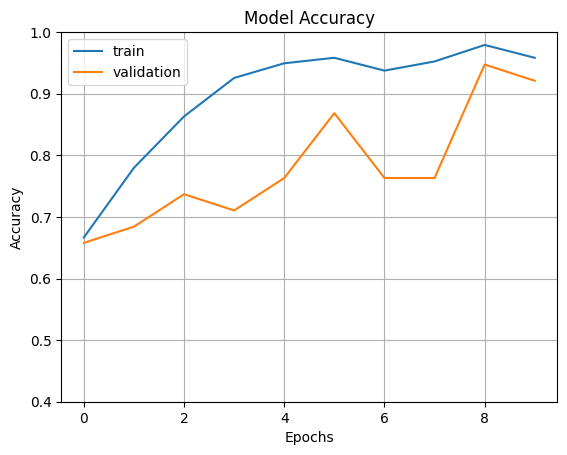

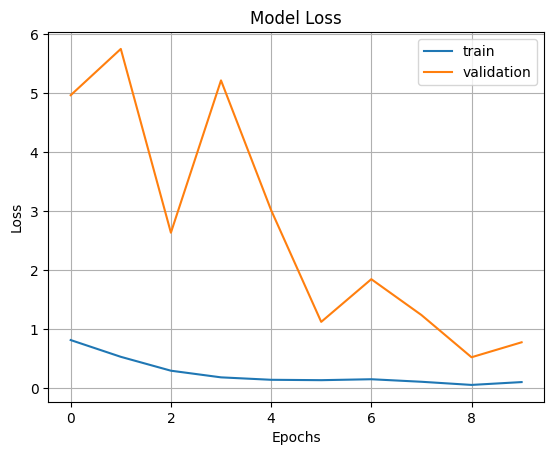

In [39]:
fig1 = plt.gcf()
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### F1- Score, Recall and Precision

In [40]:
prediction = resnet_model.predict(valid_set)
resnet_classes=np.argmax(prediction,axis=1)

2/2 [==============================] - 5s 610ms/step


In [41]:
test_labels = valid_set.classes

In [42]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, resnet_classes))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.92      0.96      0.94        25

    accuracy                           0.92        38
   macro avg       0.92      0.90      0.91        38
weighted avg       0.92      0.92      0.92        38



### Confusion Matrix

<Axes: >

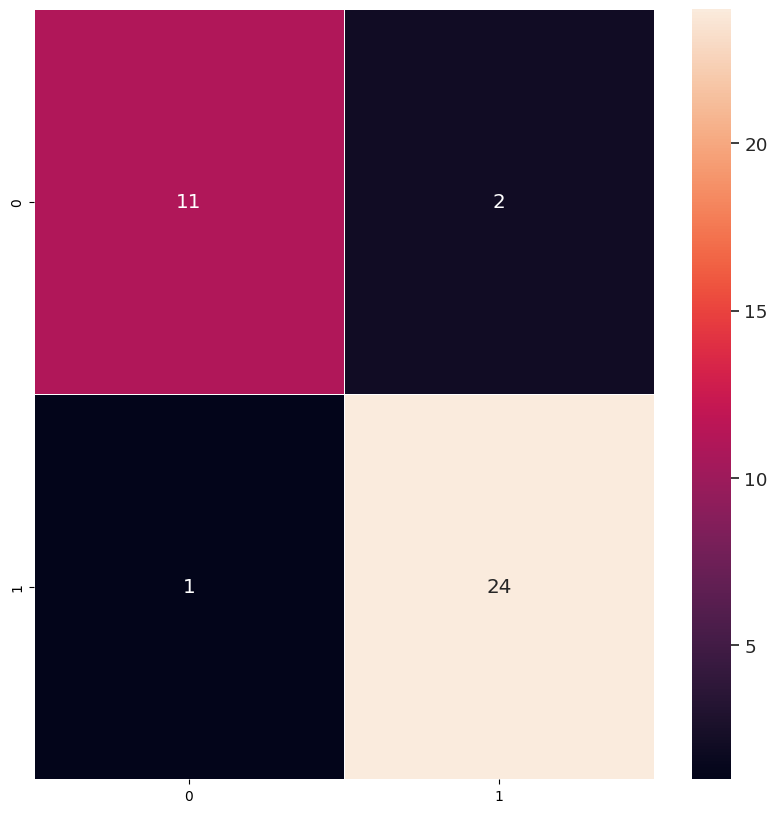

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, resnet_classes)

fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [44]:
class_names = []

for directory in glob.glob("/content/drive/MyDrive/Pokemon_Authentication_w1830176/train"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['train']


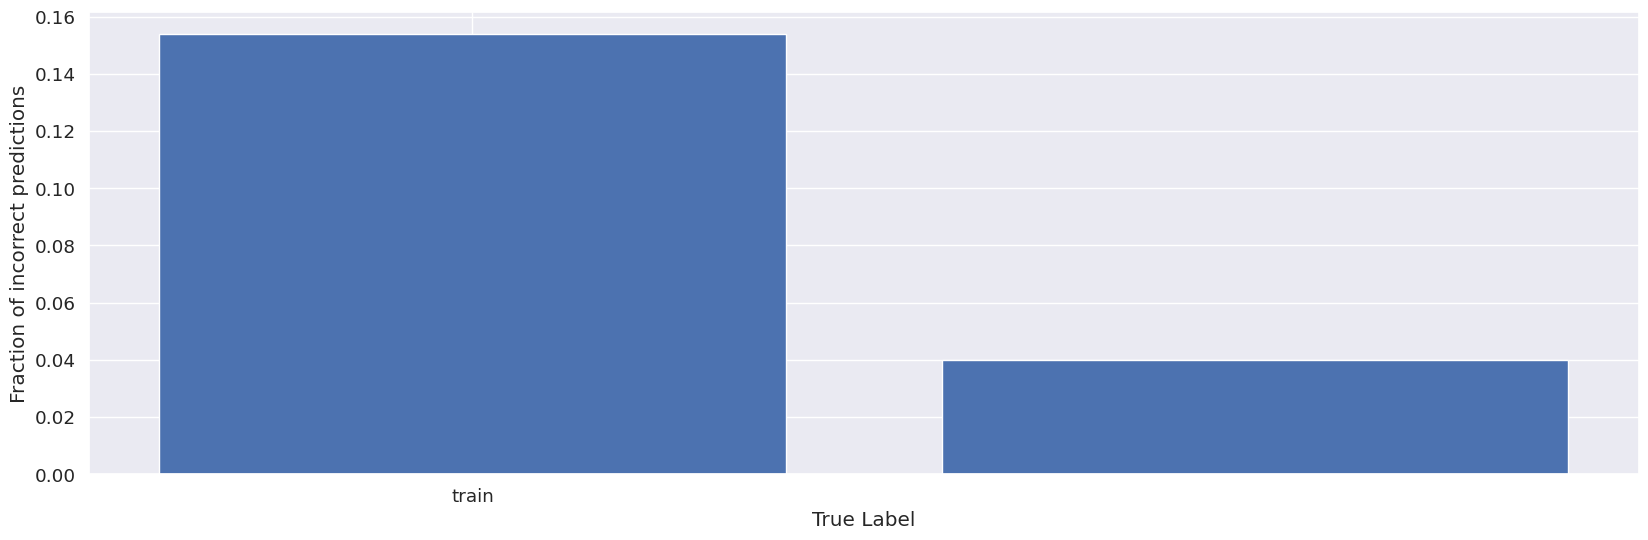

In [45]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(20,6))
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks(np.arange(1), class_names)
plt.show()

### Classification on an image

In [46]:

from tensorflow.keras.preprocessing import image

1/1 [==============================] - 1s 858ms/step
Fake Card
Value: 0.9999827


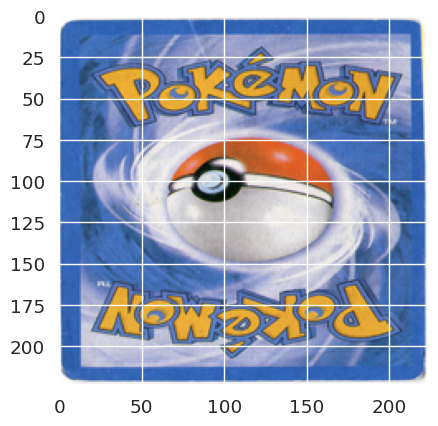

In [47]:
# def predictImage(imagePath):
#     test_img = tf.keras.utils.load_img(imagePath, target_size=(size, size))
#     test_image = tf.keras.utils.img_to_array(test_img)
#     test_image = np.expand_dims(test_image, axis=0)
#     test_image = tf.keras.applications.resnet50.preprocess_input(test_image)

#     result = resnet_model.predict(test_image)
#     x = np.amax(result)
#     if x > 0.6:
#         plt.imshow(test_img)
#         predicted_class_index = int(np.argmax(result))  # Extract a single element from the array
#         if predicted_class_index == 1:  # Check if classification is 1
#             print("Real Card")
#         else:
#             print("Fake Card")
#         print("Value:", np.amax(result))
#     else:
#         print("Can't identify the image, enter a new valid image")
#         print("Max value:", np.amax(result))

# path = '/content/drive/MyDrive/Pokemon_Authentication_w1830176/train/Real/130.JPG'
# predictImage(path)

import requests
from PIL import Image
from io import BytesIO

def predictImage(imageURL):
    response = requests.get(imageURL)
    if response.status_code == 200:
        # Load image from the response content
        image = Image.open(BytesIO(response.content))
        # Resize image to the target size
        test_img = image.resize((size, size))
        test_image = tf.keras.utils.img_to_array(test_img)
        test_image = np.expand_dims(test_image, axis=0)
        test_image = tf.keras.applications.resnet50.preprocess_input(test_image)

        result = resnet_model.predict(test_image)
        x = np.amax(result)
        if x > 0.7:
            plt.imshow(test_img)
            predicted_class_index = int(np.argmax(result))  # Extract a single element from the array
            if predicted_class_index == 1:  # Check if classification is 1
                print("Real Card")
            else:
                print("Fake Card")
            print("Value:", np.amax(result))
        else:
            print("Can't identify the image, enter a new valid image")
            print("Max value:", np.amax(result))
    else:
        print("Failed to download image from the URL")

# Example usage:
imageURL = 'https://th.bing.com/th/id/R.c16eab446f58d1286560f734928a9af5?rik=Jgctd%2f9JzK2CGw&riu=http%3a%2f%2fpoketaz.weebly.com%2fuploads%2f4%2f9%2f7%2f8%2f4978776%2f4046845_orig.jpg&ehk=MIVekFuD5AFSX5DEfMFGFjciLsWLKYKL0xkeA0vlhTc%3d&risl=&pid=ImgRaw&r=0'  # Replace with the URL of your image
predictImage(imageURL)

#Fake Image Test Link : https://th.bing.com/th/id/R.c16eab446f58d1286560f734928a9af5?rik=Jgctd%2f9JzK2CGw&riu=http%3a%2f%2fpoketaz.weebly.com%2fuploads%2f4%2f9%2f7%2f8%2f4978776%2f4046845_orig.jpg&ehk=MIVekFuD5AFSX5DEfMFGFjciLsWLKYKL0xkeA0vlhTc%3d&risl=&pid=ImgRaw&r=0


In [48]:
from tensorflow.keras.models import load_model

In [49]:
model_path = '/content/drive/MyDrive/Pokemon_Authentication_w1830176/Authentic_Model.h5'
loaded_model = load_model(model_path)